In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib as jl
from functions import *
#Reload functions module to get latest changes
import importlib
importlib.reload(__import__('functions'))

<module 'functions' from 'c:\\Users\\eskil\\OneDrive\\DTU\\6.sem\\bachelor_project\\simulation\\functions.py'>

Fundamental electric fields:
$$
E_j(z,t) = \cfrac{1}{2} [A_j(z)e^{i(k_jz-\omega_j t)}+A_j^*(z)e^{-i(k_jz-\omega_j t)}]
$$
Wavevectors: 
$$
k_j=\cfrac{n_j(\omega_j,T)\omega_j}{c} \qquad j\in \{\omega,2\omega \}
$$
Sellmeier refractive index:
$$
n_z^2(\lambda, 25^\circ\text{C}) = A + \frac{B}{1 - \frac{C}{\lambda^2}} + \frac{D}{1 - \frac{E}{\lambda^2}} - F \lambda^2.
$$
Polynomial expansion refractive index:
$$
\begin{aligned}
\Delta n_z(\lambda, T) = \quad &(T - 25) \left( a_{10} + \frac{a_{11}}{\lambda} + \frac{a_{12}}{\lambda^2} + \frac{a_{13}}{\lambda^3} \right) \\
&+ (T - 25)^2 \left( a_{20} + \frac{a_{21}}{\lambda} + \frac{a_{22}}{\lambda^2} + \frac{a_{23}}{\lambda^3} \right)
\end{aligned}
$$
Full:
$$
n_z(\lambda, T) = n_z(\lambda, 25^\circ\text{C}) + \Delta n_z (\lambda,T)
$$
Phase mismatch:
$$
\Delta k = k_{2\omega} - 2k_\omega
$$
With compensation from reciprocal lattice vector of pooled structure:
$$
\Delta k_Q = \Delta k - \cfrac{2\pi}{\Lambda(T)}
$$
Modelling $\Lambda(T)$
$$
\Lambda(T) = \Lambda_0[1+\alpha_z (T-T_0)]
$$
Effective non-linear coefficient:
$$
d_{eff} = \cfrac{2}{\pi}d_{33}
$$
Assuming an undepleted pump (Aω constant), the second-58
harmonic field at the output of a periodically poled crystal of59
length L with ideal edges (∆l,r = 0):
$$
A_{2\omega} = L e^{iL\Delta k_Q /2}\mathrm{sinc} \left(  \cfrac{L\Delta k_Q}{2} \right)
$$

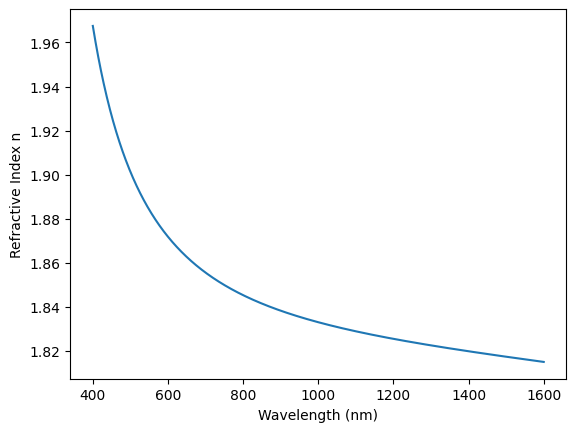

In [21]:
#Plotting refractive index as a function of wavelength
#Parameters for the Sellmeier
A = 2.12725
B = 1.18431
C = 5.14852e-2
D = 0.6603
E = 100.00507
F = 9.68956e-3
#These experimental parameters are taken from "K. Fradkin, A. Arie, A. Skliar, and G. Rosenman"
wavelengths = np.linspace(400, 1600, 1000) #Wavelengths in nm
temperature = 300  # Temperature in Kelvin
a1_list = np.array([9.9587, 9.9228, -8.9603, 4.1010])*1e-6  # Experimental values taken from S. Emanueli and A. Arie
a2_list = np.array([-1.1882 ,10.459, -9.8136, 3.1481])*1e-8  # Experimental values taken from S. Emanueli and A. Arie
n_values = refractive_index_total(temperature, A, B, C, D, E, F, a1_list, a2_list, wavelengths)
fig, ax = plt.subplots()
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Refractive Index n")
ax.plot(wavelengths, n_values)
